In [1]:
import backtrader as bt
import yfinance as yf
import pyfolio as pf
import pandas as pd

/opt/miniconda3/lib/python3.12/site-packages/pyfolio/pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
class PMAStrategy(bt.Strategy):

    def __init__(self):
        # Initialize SMA indicator
        self.sma = bt.indicators.SMA(self.data.close, period=10)  # You can change the period as desired
        self.order = None

    def next(self):
        if self.order:  # If there is an open order, do nothing
            return

        # Buy if Pt is greater than MAt(n)
        if not self.position and self.data.close[0] > self.sma[0]:
            cash = self.broker.get_cash()
            price = self.data.close[0]
            shares_to_buy = cash // price
            if shares_to_buy > 0:            
                self.log('Create Buy, %.2f' % self.data.close[0])
                self.order = self.buy(size=shares_to_buy)

        # Sell if Pt is less than MAt(n)
        elif self.position and self.data.close[0] < self.sma[0]:
            self.log('Create Sell, %.2f' % self.data.close[0])
            self.order = self.sell(size=self.position.size)

    def log(self, txt):
        dt = self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def notify_order(self, order):
        if order.status == order.Completed:
            if order.isbuy():
                self.log(
                "BUY EXECUTED (Price: %.2f, Value: %.2f, Commission %.2f)" %
                (order.executed.price, order.executed.value, order.executed.comm))
            else:
                self.log(
                "SELL EXECUTED (Price: %.2f, Value: %.2f, Commission %.2f)" %
                (order.executed.price, order.executed.value, order.executed.comm))
            self.bar_executed = len(self)
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log("Order is canceled/margin/rejected")
        self.order = None


In [3]:
def test_strategy(strategy_class, ticker, start_date, end_date, starting_cash=100000):
    cerebro = bt.Cerebro()
    cerebro.addstrategy(strategy_class)
    
    # Download data and store it in a variable
    yf_data = yf.download(ticker, start=start_date, end=end_date, multi_level_index=False)
    data = bt.feeds.PandasData(dataname=yf_data)
    cerebro.adddata(data)
    
    cerebro.broker.setcash(starting_cash)
    cerebro.broker.setcommission(commission=0)
    
    # Add observer to track portfolio value
    cerebro.addobserver(bt.observers.Value)
    
    # Add analyzer to track returns
    cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
    
    print('Initial portfolio value: %.2f' % cerebro.broker.getvalue())
    results = cerebro.run()
    print('Final portfolio value: %.2f' % cerebro.broker.getvalue())
    
    strat = results[0]
    
    # Get data from PyFolio analyzer
    portfolio_value = strat.analyzers.pyfolio.get_pf_items()
    returns, positions, transactions, gross_lev = portfolio_value

    # Get portfolio values
    portfolio_values = strat.observers.value.get(size=len(strat))
    
    # Create DataFrame with dates and portfolio values
    df_portfolio = pd.DataFrame({
        'Date': yf_data.index,
        'Value': portfolio_values
    })    
    
    # Use pyfolio to generate report
    pf.create_simple_tear_sheet(returns)

    return df_portfolio

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Initial portfolio value: 100000.00
2024-08-14, Create Buy, 170.10
2024-08-15, Order is canceled/margin/rejected
2024-08-15, Create Buy, 177.59
2024-08-16, BUY EXECUTED (Price: 177.04, Value: 99673.52, Commission 0.00)
2024-08-26, Create Sell, 175.50
2024-08-27, SELL EXECUTED (Price: 174.15, Value: 99673.52, Commission 0.00)
2024-08-30, Create Buy, 178.50
2024-09-03, BUY EXECUTED (Price: 177.55, Value: 97830.05, Commission 0.00)
2024-09-04, Create Sell, 173.33
2024-09-05, SELL EXECUTED (Price: 175.00, Value: 97830.05, Commission 0.00)
2024-09-05, Create Buy, 177.89
2024-09-06, BUY EXECUTED (Price: 177.24, Value: 96595.80, Commission 0.00)
2024-09-06, Create Sell, 171.39
2024-09-09, SELL EXECUTED (Price: 174.53, Value: 96595.80, Commission 0.00)
2024-09-09, Create Buy, 175.40
2024-09-10, Order is canceled/margin/rejected
2024-09-10, Create Buy, 179.55
2024-09-11, Order is canceled/margin/rejected
2024-09-11, Create Buy, 184.52
2024-09-12, Order is canceled/margin/rejected
2024-09-12, Cre


/opt/miniconda3/lib/python3.12/site-packages/pyfolio/plotting.py:670: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '13.367%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100, 3)) + "%"


Start date,2024-08-01
End date,2025-02-27
Total months,6
,Backtest
Annual return,13.367%
Cumulative returns,7.432%
Annual volatility,20.544%
Sharpe ratio,0.71
Calmar ratio,1.43
Stability,0.54
Max drawdown,-9.347%


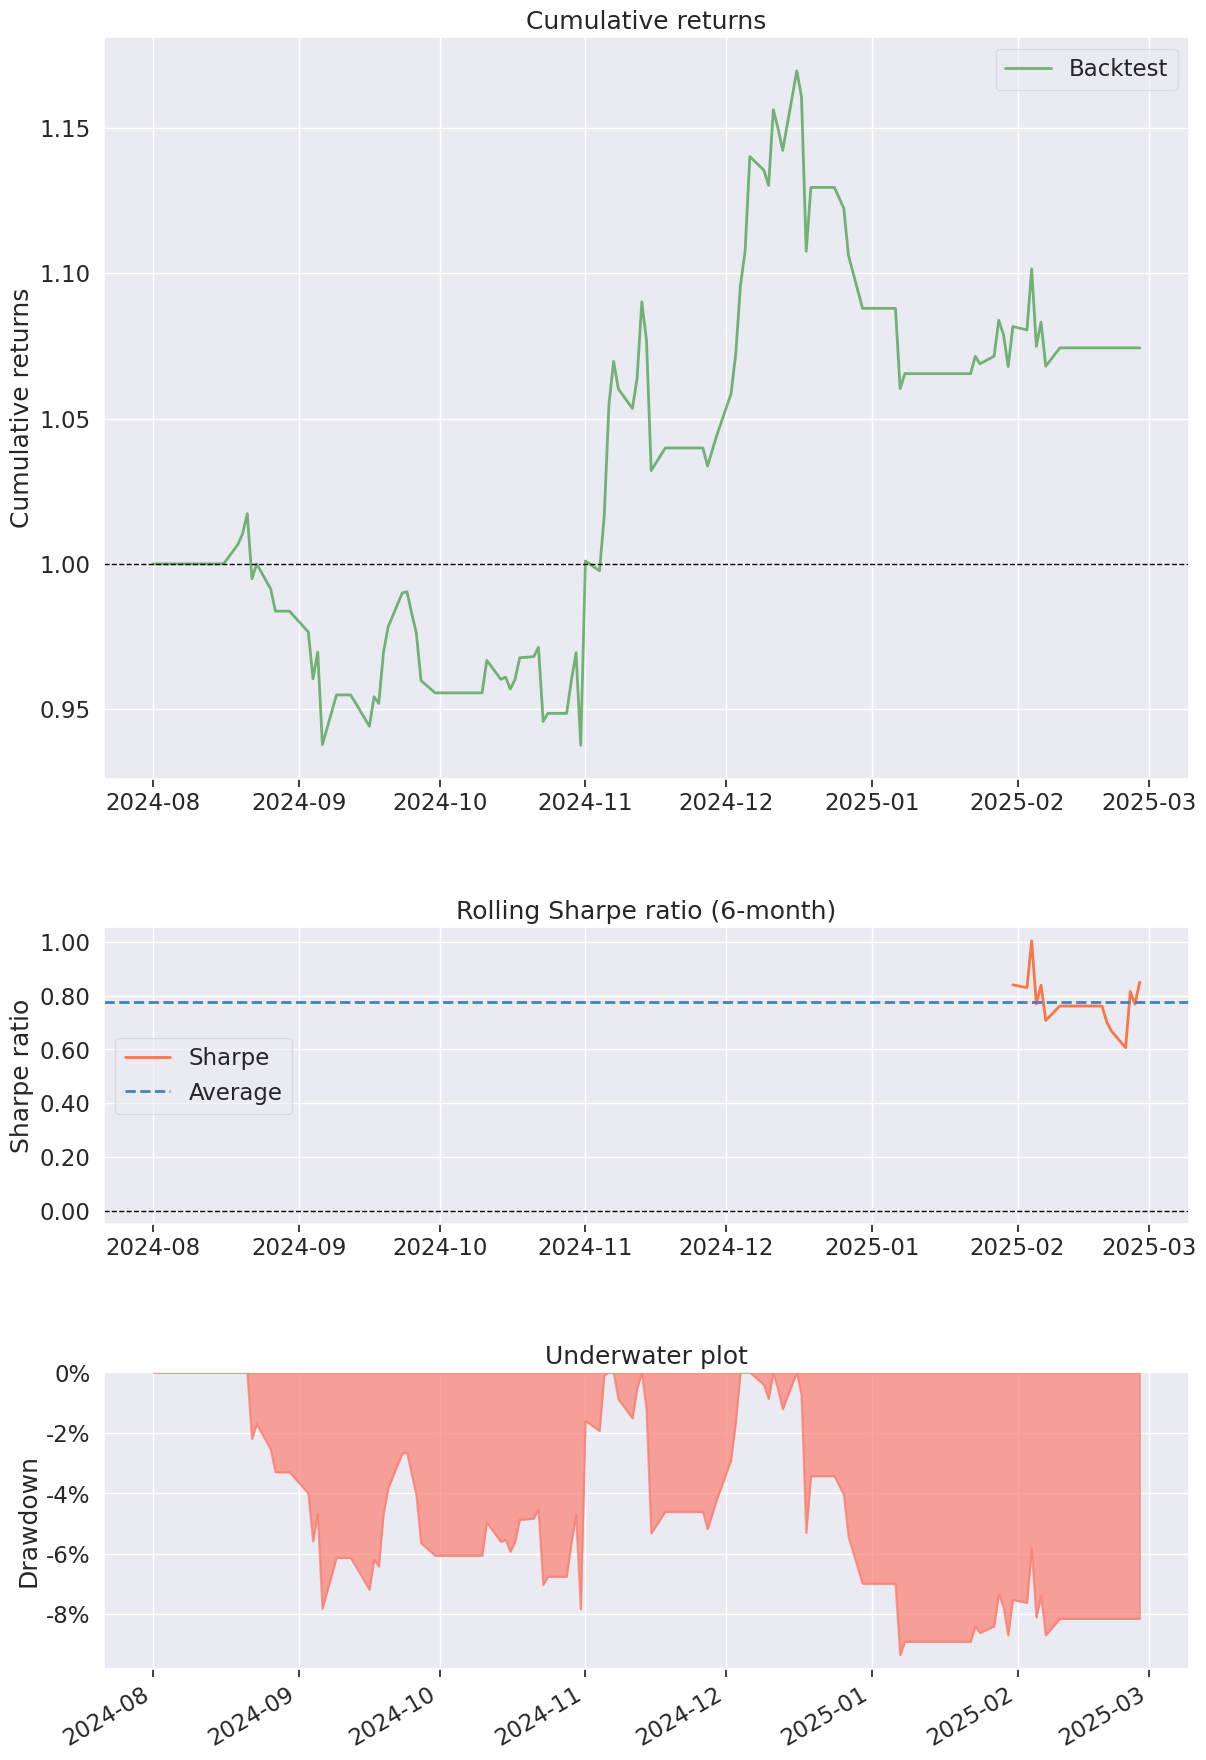

In [4]:
results = test_strategy(PMAStrategy, 'AMZN', '2024-08-01', '2025-02-28')

In [5]:
import pickle

# Za df_account_value_sac
with open('results/amzn_p_ma_strategy.pkl', 'wb') as f:
    pickle.dump(results, f)